In [11]:
# Created by: Dhruv Bejugam
# Last Updated on: 07/21/22
# Summary: PyTorch PDE Approximator created for sinusoidal PDE using random points
# References: "Solving Partial Differential Equations with Neural Networks" by Juan B. Pedro, Juan Maroñas, Roberto Paredes

In [ ]:
%matplotlib inline

In [ ]:
# import required packages
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn

In [ ]:
# defining function to get tensor filled with random numbers from 0 to 1
def get_samples(batch_size=100, n_inputs=2):  
    return torch.rand((batch_size, n_inputs)) 

In [ ]:
# setting 'X' as tensor of size (5, 2) 
X = get_samples(5, 2)

# setting 'x' as tensor with values from the first column of 'X' and 't' as tensor with values from second column of 'X'
x, t = X[:,0], X[:,1]

In [ ]:
# Sine activation function
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# defining the sequential neural network and its layers
mlp = nn.Sequential(
	nn.Linear(2, 100),
	Sine(), 
	nn.Linear(100, 100), 
	Sine(), 
	nn.Linear(100, 1)
)

mlp

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Sine()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sine()
  (4): Linear(in_features=100, out_features=1, bias=True)
)

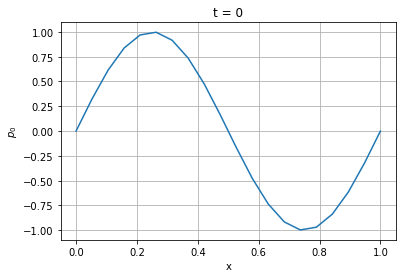

In [7]:
# graph at initial condition (t = 0)
x= np.linspace(0, 1, 20)
p0 = np.sin(2*np.pi*x)

plt.plot(x, p0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.title('t = 0')
plt.show()

In [8]:
# function to get points at initial conditionns
def get_samples_ini(batch_size=100):
    x = torch.rand(batch_size)
    p0 = torch.sin(2.*np.pi*x).unsqueeze(1)
    return torch.stack([  
        x,
        torch.zeros(batch_size)
    ], axis=-1), p0

In [9]:
# function to get points at boundary conditions (peridic conditions at x = 0 and x = 1)

def get_samples_boco(batch_size=100):
    t = torch.rand(batch_size)
    X0 = torch.stack([  
        torch.zeros(batch_size),
        t
    ], axis=-1)
    X1 = torch.stack([  
        torch.ones(batch_size),
        t
    ], axis=-1)
    return X0, X1

In [12]:
BATCH_SIZE = 100
N_STEPS = 5000
U = 1

optimizer = torch.optim.Adam(mlp.parameters()) # optimizer function
criterion = torch.nn.MSELoss() # loss function

hist = []
log_each = 500
for step in range(1, N_STEPS+1): # training model

    # optimize for PDE
    X = get_samples(BATCH_SIZE, 2) 
    X.requires_grad_(True)
    y_hat = mlp(X) 
    grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdx, dpdt = grads[:,0], grads[:,1]
    pde_loss = criterion(dpdt, - U*dpdx)

    # optimize for initial condition
    X, p0 = get_samples_ini(BATCH_SIZE)
    y_hat = mlp(X)
    ini_loss = criterion(y_hat, p0)  
    
    # optimize for boundary conditions
    X0, X1 = get_samples_boco(BATCH_SIZE)
    y_0 = mlp(X0) 
    y_1 = mlp(X1)
    bound_loss = criterion(y_0, y_1)

    # update
    optimizer.zero_grad()
    loss = pde_loss + ini_loss + bound_loss
    loss.backward()
    optimizer.step()
   
    # printing loss
    hist.append(loss.item())
    if step % log_each == 0:
        print(f'{step}/{N_STEPS} pde_loss {pde_loss.item():.5f} ini_loss {ini_loss.item():.5f} bound_loss {bound_loss.item():.5f}')

500/5000 pde_loss 0.00001 ini_loss 0.00001 bound_loss 0.00002
1000/5000 pde_loss 0.00003 ini_loss 0.00001 bound_loss 0.00002
1500/5000 pde_loss 0.00003 ini_loss 0.00001 bound_loss 0.00002
2000/5000 pde_loss 0.00001 ini_loss 0.00003 bound_loss 0.00002
2500/5000 pde_loss 0.00002 ini_loss 0.00001 bound_loss 0.00002
3000/5000 pde_loss 0.00001 ini_loss 0.00002 bound_loss 0.00002
3500/5000 pde_loss 0.00001 ini_loss 0.00001 bound_loss 0.00001
4000/5000 pde_loss 0.00002 ini_loss 0.00001 bound_loss 0.00001
4500/5000 pde_loss 0.00001 ini_loss 0.00001 bound_loss 0.00002
5000/5000 pde_loss 0.00001 ini_loss 0.00001 bound_loss 0.00001


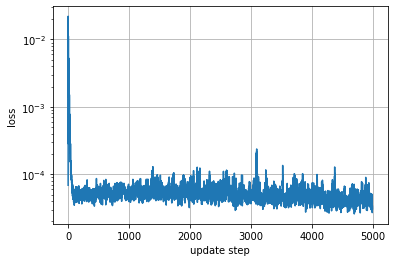

In [13]:
# graphing loss over time
plt.plot(hist)
plt.xlabel("update step")
plt.ylabel("loss")
plt.yscale("log")
plt.grid(True)
plt.show()

In [14]:
# function for evaluating model at specific points
def eval_model(N=10, t=0.):
    x = torch.linspace(0, 1, N)
    X = torch.stack([
        x,
        torch.ones(N)*t
    ], axis=-1)
    mlp.eval()
    with torch.no_grad():
        p = mlp(X)
    return x.numpy(), p.numpy().ravel()

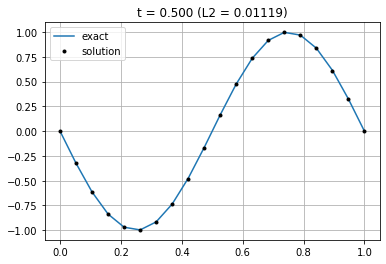

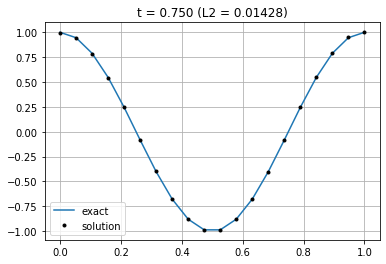

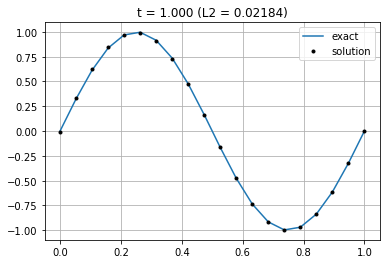

In [15]:
# function for plotting solution
def plot_model(x, p, t):
    pe = np.sin(2.*np.pi*(x-U*t))
    plt.plot(x, pe, label="exact")
    plt.plot(x, p, '.k', label="solution")
    plt.legend()
    plt.grid(True)
    l2 = np.sqrt(np.sum((p-pe)**2))
    plt.title(f"t = {t:.3f} (L2 = {l2:.5f})")
    plt.show()
  
# plotting model at different times
x, p = eval_model(N=20, t=0.5)
plot_model(x, p, 0.5)
x, p = eval_model(N=20, t=0.75)
plot_model(x, p, 0.75)
x, p = eval_model(N=20, t=1)
plot_model(x, p, 1)